In [27]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from collections import Counter

# Spilt dataset (Base on layer)
import os #Iterate folder, create new catalog
import shutil #File operation - move file, etc
from sklearn.model_selection import train_test_split

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Pre-training Model
from tensorflow.keras.applications import Xception, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout

### Data Preparation ans data cleaning <br>
Dataset: Intel Image Classification<br>
https://www.kaggle.com/datasets/puneet6060/intel-image-classification <br>
- Load dataset<br>
- spilt to 3 dataset - train/validation/test<br>
- Image Normalization and standardlization<br>

In [28]:
train_dir = './intel-image-classification/seg_train/seg_train'
test_dir = './intel-image-classification/seg_test/seg_test'

In [29]:
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

#### EDA  (Exploratory Data Analysis)
- Data structure
- Img/Label shape
- Class distribution
- Visualize pictures

In [30]:
# Load dataset, Implicit regularization
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [31]:
# View dataset information
for images, labels in train_ds.take(1): #Extract one batch
    print(f"Images shape: {images.shape}")  # fig shape
    print(f"Labels shape: {labels.shape}")  # label shape
    print(f"Image max value: {tf.reduce_max(images)}")
    print(f"Image min value: {tf.reduce_min(images)}")  

for images, labels in test_ds.take(1):    
    print(f"Images shape: {images.shape}")  # fig shape
    print(f"Labels shape: {labels.shape}")  # label shape

Images shape: (32, 150, 150, 3)
Labels shape: (32,)
Image max value: 255.0
Image min value: 0.0
Images shape: (32, 150, 150, 3)
Labels shape: (32,)


In [32]:
class_list = train_ds.class_names
print(f"class_names: {class_list}")

class_names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [33]:
label_count = Counter()

for image, labels in train_ds: #batch
    label_indices = labels.numpy()
    for index in label_indices:
        class_names = class_list[index]
        label_count[class_names] += 1
for class_name, count in sorted(label_count.items()):
    print(f"{class_name}: {count}")

buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


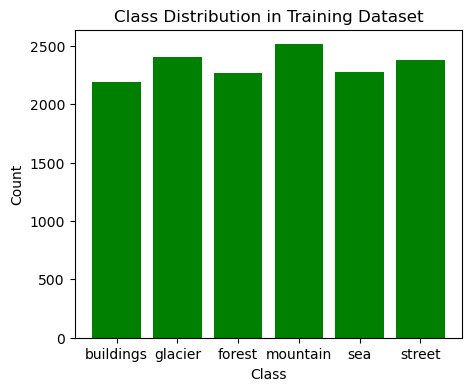

In [34]:
# Check label distribution
classes, counts = zip(*label_count.items())

plt.figure(figsize=(5,4))
plt.bar(classes, counts, color='green')
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

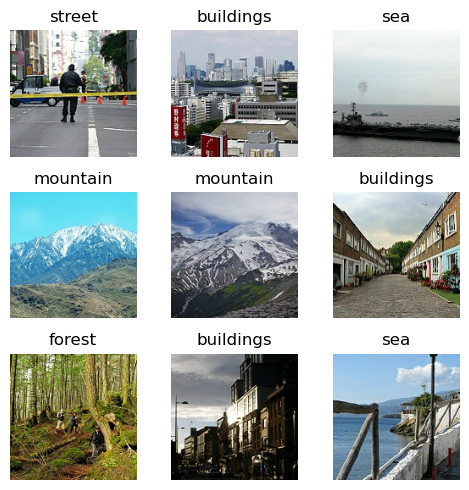

In [35]:
# Visible data
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):  # Extract one batch
    for i in range(9):  # Display first 9 pics
        ax = plt.subplot(3, 3, i + 1) #layout
        plt.imshow(images[i].numpy().astype("uint8"))  # img convert to NumPy and display
        label_index = labels[i].numpy()  # Extract the numeric index of labels
        plt.title(class_list[label_index])  # Map num index to a text class
        plt.axis("off")
plt.tight_layout()
plt.show()


#### Spilt Dataset

In [36]:
val_dir = './intel-image-classification/seg_val'
os.makedirs(val_dir, exist_ok=True) #No error when directory already exists

In [37]:
#Go through every folder - category
for class_name in class_list:
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path): #make sure it's a folder
        continue
    
    images = os.listdir(class_path)
    train_images, val_images = train_test_split(
        images,
        test_size=0.2,
        random_state=42
    )
    
    val_class_path = os.path.join(val_dir, class_name)
    os.makedirs(val_class_path, exist_ok=True) #No error when directory already exists
    
    for img_name in val_images:
        src_path = os.path.join(class_path, img_name)
        dest_path = os.path.join(val_class_path, img_name)
        shutil.move(src_path, dest_path) # move from source to target path
    

In [38]:
#Go through every folder - category
for class_name in class_list:
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path): #make sure it's a folder
        continue
    
    images = os.listdir(class_path)
    train_images, val_images = train_test_split(
        images,
        test_size=0.2,
        random_state=42
    )
    
    val_class_path = os.path.join(val_dir, class_name)
    os.makedirs(val_class_path, exist_ok=True) #No error when directory already exists
    
    for img_name in val_images:
        src_path = os.path.join(class_path, img_name)
        dest_path = os.path.join(val_class_path, img_name)
        shutil.move(src_path, dest_path) # move from source to target path
    

In [39]:
def count_images_in_dir(directory):
    
    total_count = 0
    print(f"{directory}")
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            print(f"{class_name}: {num_images} pictures")
            total_count += num_images
    print(f"Total Pictures: {total_count}")
label_count = Counter()

count_images_in_dir('./intel-image-classification/seg_train/seg_train')
count_images_in_dir('./intel-image-classification/seg_val')

./intel-image-classification/seg_train/seg_train
forest: 1452 pictures
sea: 1455 pictures
glacier: 1538 pictures
buildings: 1401 pictures
street: 1524 pictures
mountain: 1607 pictures
Total Pictures: 8977
./intel-image-classification/seg_val
forest: 819 pictures
sea: 819 pictures
glacier: 866 pictures
buildings: 790 pictures
street: 858 pictures
mountain: 905 pictures
Total Pictures: 5057


### Define Model

In [40]:
train_dir = './intel-image-classification/seg_train/seg_train'
test_dir = './intel-image-classification/seg_test/seg_test'
val_dir = './intel-image-classification/seg_val'

#### Transfer learning

In [41]:
# Image augmentation and preprocessing
# Pre-process, scale px value to [-1.1]
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest')
train_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='sparse'
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_ds = test_gen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='sparse'
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='sparse'
)

Found 8977 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 5057 images belonging to 6 classes.


In [42]:
images, labels = next(train_ds)  # 提取一個批次
print(f"Images shape: {images.shape}")  # 圖片形狀
print(f"Labels shape: {labels.shape}")  # 標籤形狀
print(f"Pixel range: {images.min()} to {images.max()}")

Images shape: (32, 150, 150, 3)
Labels shape: (32,)
Pixel range: -1.0 to 1.0


#### Base Model Structure

In [43]:
# Define Model
def create_model(
    input_shape = (150,150,3),
    base_model_name = 'Xception',
    trainable=False,
    learning_rate = 0.001,
    size_inner = 128,
    droprate=0.5,
    num_classes = len(train_ds.class_indices),
):

    if base_model_name == 'Xception':
        base_model = Xception(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )
    else:
        raise ValueError(f"Unsupported base model: {base_model_name}")

    base_model.trainable = trainable #Freeze or unfreeze the parameters of the pre-training model

    #model structure
    inputs = Input(shape=input_shape) #input layer
    base = base_model(inputs, training=False) #pre-training extract features
    vectors= GlobalAveragePooling2D()(base) #pooling, 4D to 2D
    dropout_vectors = Dropout(droprate)(vectors) #dropout: random abandon some features
    inner = Dense(size_inner, activation = 'relu')(dropout_vectors) #relu activation
    dropout_inner = Dropout(droprate)(inner) #dropout: enhanced normalization
    outputs = Dense(num_classes, activation='softmax')(dropout_inner)

    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    return model


### Model selection process and parameter tuning

In [45]:
# Learning Rate
histories_lr = {}

for lr in [0.0001, 0.001, 0.01]:
    print(f"\nTraining model with learning_rate={lr}")
    
    model = create_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=5, validation_data=val_ds)
    
    histories_lr[f"lr={lr}"] = history.history


Training model with learning_rate=0.0001
Epoch 1/5
281/281 [==============================] - 26s 86ms/step - loss: 1.2107 - accuracy: 0.5384 - val_loss: 0.5602 - val_accuracy: 0.8262
Epoch 2/5
281/281 [==============================] - 25s 88ms/step - loss: 0.7271 - accuracy: 0.7365 - val_loss: 0.4225 - val_accuracy: 0.8634
Epoch 3/5
281/281 [==============================] - 24s 86ms/step - loss: 0.6211 - accuracy: 0.7681 - val_loss: 0.3771 - val_accuracy: 0.8725
Epoch 4/5
281/281 [==============================] - 24s 86ms/step - loss: 0.5715 - accuracy: 0.7915 - val_loss: 0.3594 - val_accuracy: 0.8788
Epoch 5/5
281/281 [==============================] - 42s 148ms/step - loss: 0.5389 - accuracy: 0.8000 - val_loss: 0.3379 - val_accuracy: 0.8835

Training model with learning_rate=0.001
Epoch 1/5
281/281 [==============================] - 68s 232ms/step - loss: 0.6866 - accuracy: 0.7452 - val_loss: 0.3567 - val_accuracy: 0.8713
Epoch 2/5
281/281 [==============================] - 66s 

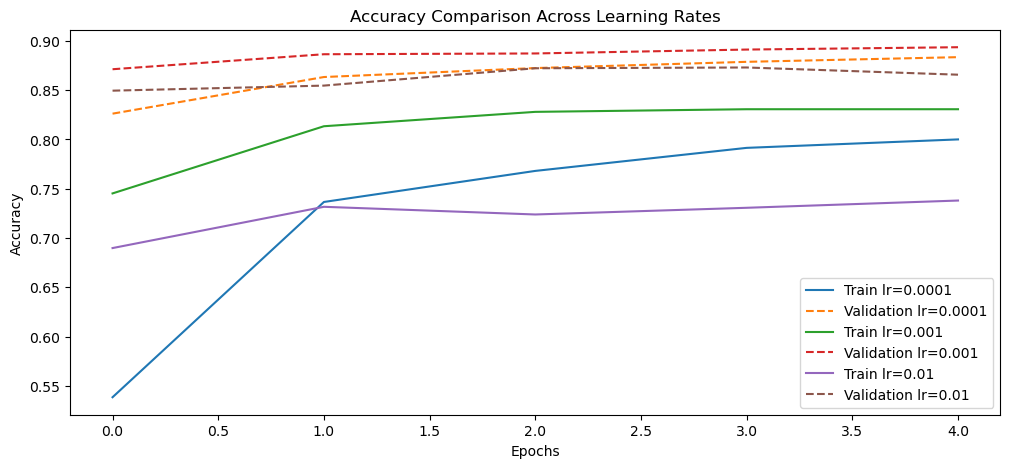

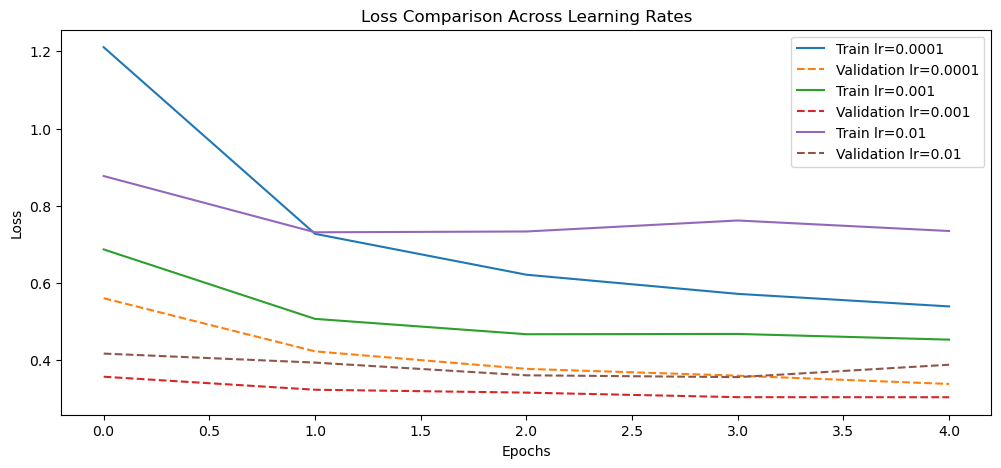

In [46]:
plt.figure(figsize=(12, 5))
for lr, hist in histories_lr.items():
    plt.plot(hist["accuracy"], label=f"Train {lr}")
    plt.plot(hist["val_accuracy"], '--', label=f"Validation {lr}")

plt.title("Accuracy Comparison Across Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
for lr, hist in histories_lr.items():
    plt.plot(hist["loss"], label=f"Train {lr}")
    plt.plot(hist["val_loss"], '--', label=f"Validation {lr}")

plt.title("Loss Comparison Across Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [47]:
# Model selection
histories_model = {}

for model_name in ['Xception', 'ResNet50']:
    print(f"\nTraining model with model = {model_name}")
    
    model = create_model(base_model_name = model_name)
    history = model.fit(train_ds, epochs=5, validation_data=val_ds)
    
    histories_model[f"model={model_name}"] = history.history


Training model with model = Xception


Epoch 1/5
281/281 [==============================] - 68s 233ms/step - loss: 0.6788 - accuracy: 0.7445 - val_loss: 0.3426 - val_accuracy: 0.8790
Epoch 2/5
281/281 [==============================] - 59s 211ms/step - loss: 0.5128 - accuracy: 0.8134 - val_loss: 0.3312 - val_accuracy: 0.8784
Epoch 3/5
281/281 [==============================] - 64s 220ms/step - loss: 0.4730 - accuracy: 0.8267 - val_loss: 0.3189 - val_accuracy: 0.8841
Epoch 4/5
281/281 [==============================] - 62s 220ms/step - loss: 0.4580 - accuracy: 0.8299 - val_loss: 0.3102 - val_accuracy: 0.8821
Epoch 5/5
281/281 [==============================] - 61s 219ms/step - loss: 0.4579 - accuracy: 0.8349 - val_loss: 0.2936 - val_accuracy: 0.8926

Training model with model = ResNet50
Epoch 1/5
281/281 [==============================] - 72s 247ms/step - loss: 1.6915 - accuracy: 0.2668 - val_loss: 1.4370 - val_accuracy: 0.3923
Epoch 2/5
281/281 [==============================] - 65s 231ms/step - loss: 1.5021 - accuracy: 0.3

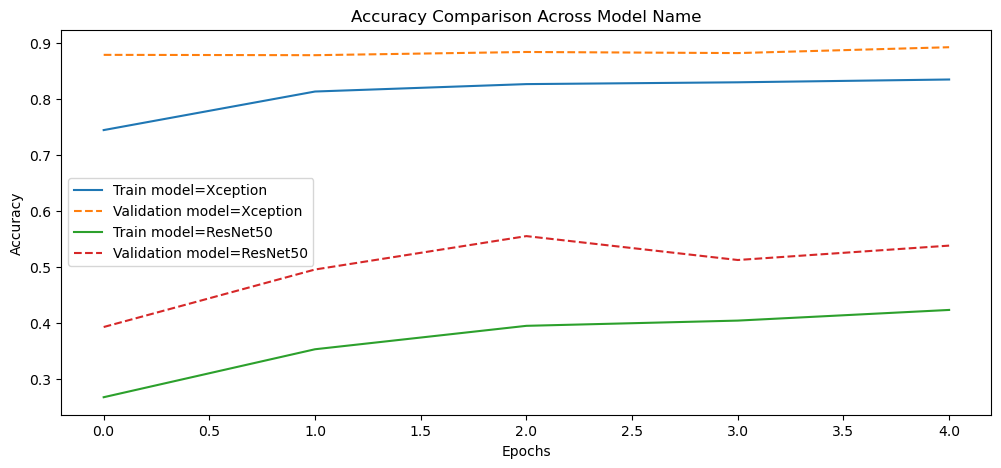

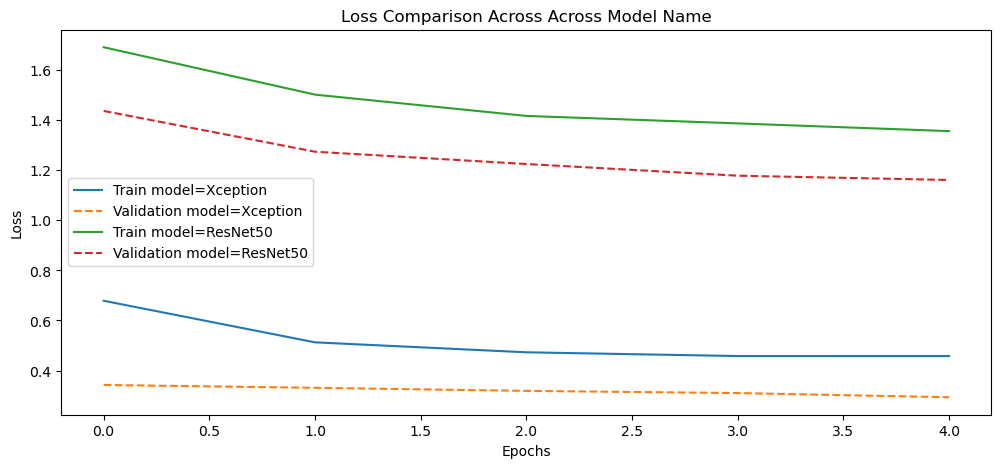

In [48]:
plt.figure(figsize=(12, 5))
for model_name, hist in histories_model.items():
    plt.plot(hist["accuracy"], label=f"Train {model_name}")
    plt.plot(hist["val_accuracy"], '--', label=f"Validation {model_name}")

plt.title("Accuracy Comparison Across Model Name")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
for model_name, hist in histories_model.items():
    plt.plot(hist["loss"], label=f"Train {model_name}")
    plt.plot(hist["val_loss"], '--', label=f"Validation {model_name}")

plt.title("Loss Comparison Across Across Model Name")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [49]:
# Size inner
histories_size_inner = {}

for size_inner in [64, 128, 256]:
    print(f"\nTraining model with size_inner = {size_inner}")
    
    model = create_model(size_inner = size_inner)
    history = model.fit(train_ds, epochs=5, validation_data=val_ds)
    
    histories_size_inner[f"size_inner={size_inner}"] = history.history


Training model with size_inner = 64
Epoch 1/5
281/281 [==============================] - 65s 222ms/step - loss: 0.7858 - accuracy: 0.7127 - val_loss: 0.3506 - val_accuracy: 0.8657
Epoch 2/5
281/281 [==============================] - 61s 219ms/step - loss: 0.5577 - accuracy: 0.7982 - val_loss: 0.3355 - val_accuracy: 0.8796
Epoch 3/5
281/281 [==============================] - 62s 220ms/step - loss: 0.5081 - accuracy: 0.8185 - val_loss: 0.3193 - val_accuracy: 0.8899
Epoch 4/5
281/281 [==============================] - 62s 220ms/step - loss: 0.4900 - accuracy: 0.8215 - val_loss: 0.3235 - val_accuracy: 0.8792
Epoch 5/5
281/281 [==============================] - 61s 219ms/step - loss: 0.4778 - accuracy: 0.8277 - val_loss: 0.3033 - val_accuracy: 0.8899

Training model with size_inner = 128
Epoch 1/5
281/281 [==============================] - 65s 222ms/step - loss: 0.6929 - accuracy: 0.7495 - val_loss: 0.3356 - val_accuracy: 0.8778
Epoch 2/5
281/281 [==============================] - 61s 219m

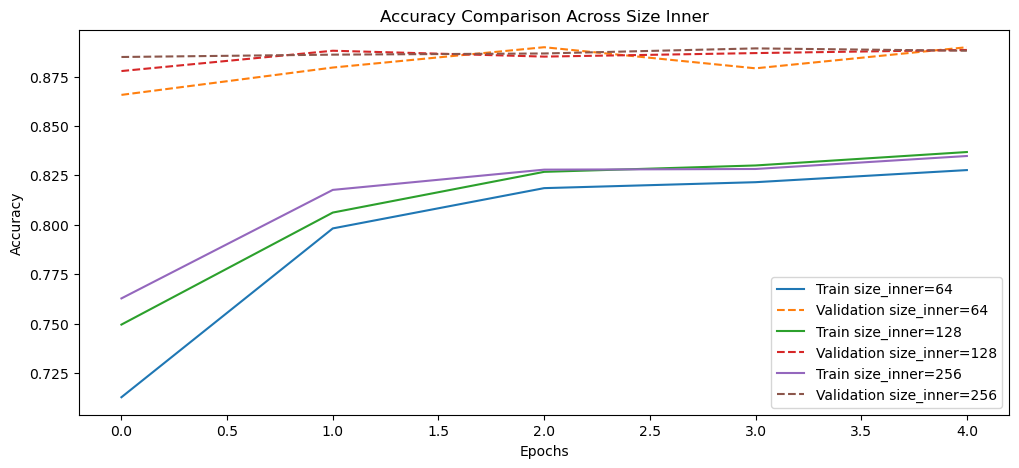

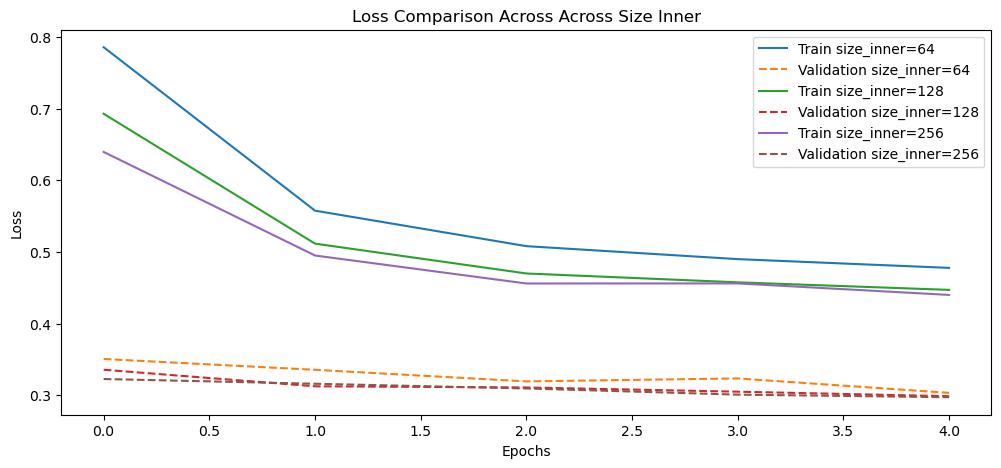

In [50]:
plt.figure(figsize=(12, 5))
for size_inner, hist in histories_size_inner.items():
    plt.plot(hist["accuracy"], label=f"Train {size_inner}")
    plt.plot(hist["val_accuracy"], '--', label=f"Validation {size_inner}")

plt.title("Accuracy Comparison Across Size Inner")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
for size_inner, hist in histories_size_inner.items():
    plt.plot(hist["loss"], label=f"Train {size_inner}")
    plt.plot(hist["val_loss"], '--', label=f"Validation {size_inner}")

plt.title("Loss Comparison Across Across Size Inner")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [51]:
# Droprate
histories_droprate = {}

for droprate in [0.3, 0.5, 0.7]:
    print(f"\nTraining model with droprate = {droprate}")
    
    model = create_model(droprate = droprate)
    history = model.fit(train_ds, epochs=5, validation_data=val_ds)
    
    histories_droprate[f"droprate={droprate}"] = history.history


Training model with droprate = 0.3
Epoch 1/5
281/281 [==============================] - 65s 221ms/step - loss: 0.5607 - accuracy: 0.7930 - val_loss: 0.3483 - val_accuracy: 0.8657
Epoch 2/5
281/281 [==============================] - 61s 219ms/step - loss: 0.4412 - accuracy: 0.8388 - val_loss: 0.3129 - val_accuracy: 0.8837
Epoch 3/5
281/281 [==============================] - 38s 134ms/step - loss: 0.4057 - accuracy: 0.8505 - val_loss: 0.2904 - val_accuracy: 0.8932
Epoch 4/5
281/281 [==============================] - 24s 85ms/step - loss: 0.3801 - accuracy: 0.8586 - val_loss: 0.2913 - val_accuracy: 0.8946
Epoch 5/5
281/281 [==============================] - 24s 85ms/step - loss: 0.3781 - accuracy: 0.8585 - val_loss: 0.2850 - val_accuracy: 0.8958

Training model with droprate = 0.5
Epoch 1/5
281/281 [==============================] - 27s 89ms/step - loss: 0.6797 - accuracy: 0.7529 - val_loss: 0.3367 - val_accuracy: 0.8788
Epoch 2/5
281/281 [==============================] - 24s 84ms/step 

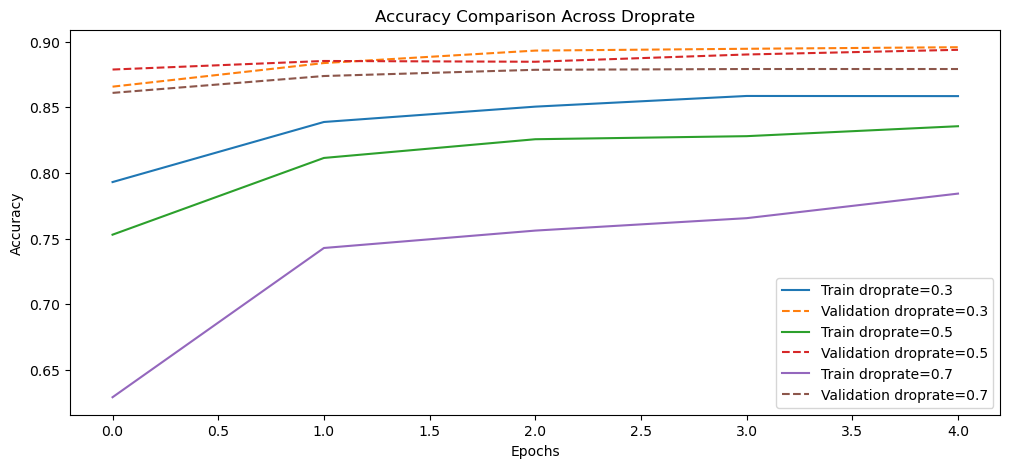

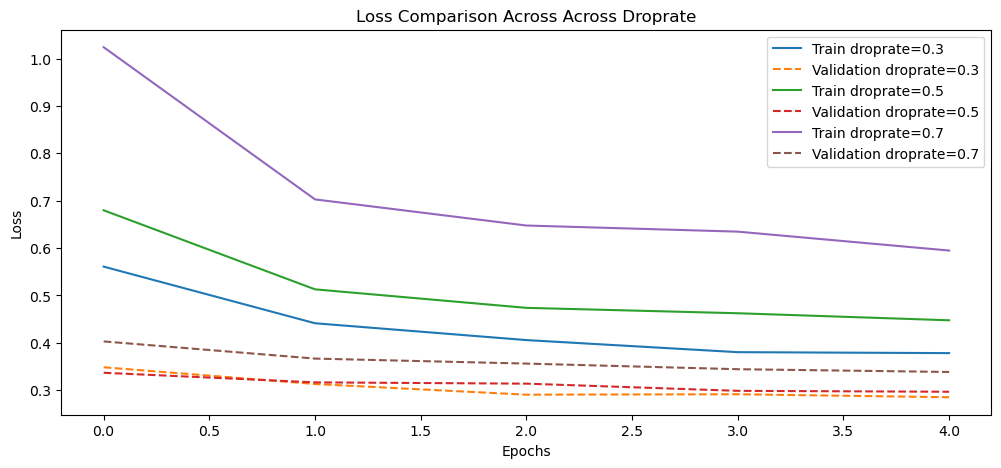

In [52]:
plt.figure(figsize=(12, 5))
for droprate, hist in histories_droprate.items():
    plt.plot(hist["accuracy"], label=f"Train {droprate}")
    plt.plot(hist["val_accuracy"], '--', label=f"Validation {droprate}")

plt.title("Accuracy Comparison Across Droprate")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
for droprate, hist in histories_droprate.items():
    plt.plot(hist["loss"], label=f"Train {droprate}")
    plt.plot(hist["val_loss"], '--', label=f"Validation {droprate}")

plt.title("Loss Comparison Across Across Droprate")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()